In [3]:
import os
import cv2
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from torchvision.transforms import Resize
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Setup #1
Train: Lego <br>
Test: Lego

In [4]:
# origial image path
origial_images = 'D:/CentraleSupelec/BDRP/denoising repo/MIRNetv2/Real_Denoising/Datasets/originalNeRF/original'
# reconstructed image
reconstructed_images = 'D:/CentraleSupelec/BDRP/denoising repo/MIRNetv2/Real_Denoising/Datasets/originalNeRF/reconstructed'
# denoised image
denoised_images = 'D:/CentraleSupelec/BDRP/denoising repo/MIRNetv2/Real_Denoising/Datasets/originalNeRF/denoised'

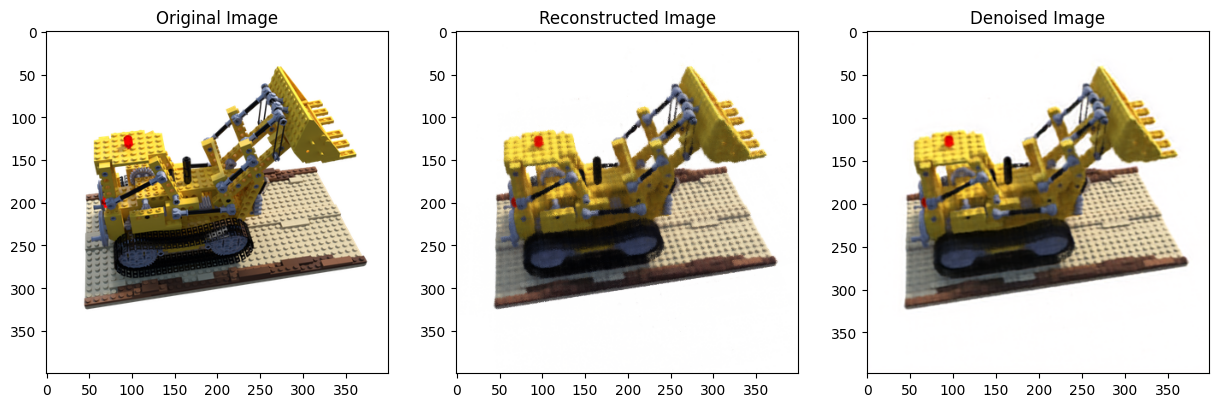

In [5]:
# take sample image from the original images, reconstructed images and denoised images with name 22.png
sample_original_image = cv2.imread(os.path.join(origial_images, '22.png'))
sample_reconstructed_image = cv2.imread(os.path.join(reconstructed_images, '22.png'))
sample_denoised_image = cv2.imread(os.path.join(denoised_images, '22.png'))
# show the images in the same window
plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(sample_original_image, cv2.COLOR_BGR2RGB))
plt.subplot(132)
plt.title('Reconstructed Image')
plt.imshow(cv2.cvtColor(sample_reconstructed_image, cv2.COLOR_BGR2RGB))
plt.subplot(133)
plt.title('Denoised Image')
plt.imshow(cv2.cvtColor(sample_denoised_image, cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
def calculate_residual(original_path, reconstructed_path):
    resize_transform = Resize((398, 398))
    # Read the original and reconstructed images
    original = cv2.imread(original_path, cv2.IMREAD_UNCHANGED)
    # original = cv2.resize(original, (398, 398))
    reconstructed = cv2.imread(reconstructed_path, cv2.IMREAD_UNCHANGED)
    # reconstructed = cv2.resize(reconstructed, (398, 398))
    
    # Convert images to float for accurate subtraction
    original_float = original.astype(np.float32)
    reconstructed_float = reconstructed.astype(np.float32)
    
    # Calculate the residual
    residual = original_float - reconstructed_float
    
    # Clip values to the range [0, 255] and convert to uint8
    # residual_clipped = np.clip(residual, 0, 255).astype(np.uint8)
    
    return residual

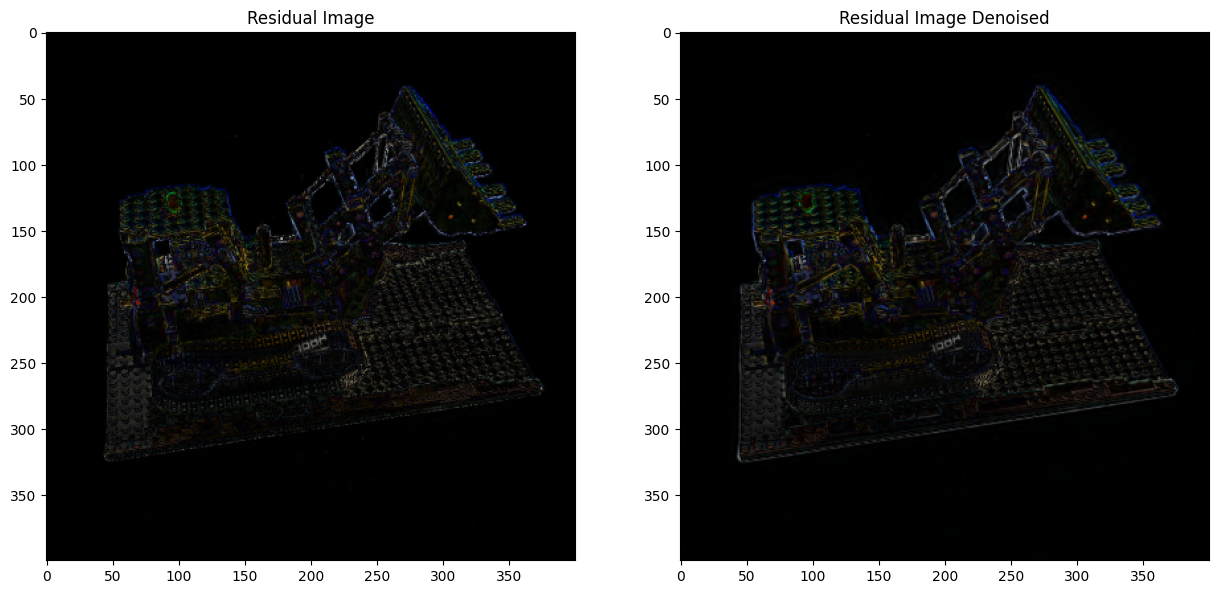

In [7]:
# calcualte the residual image between the original and the reconstructed image for the sample image
residual_image = cv2.absdiff(sample_original_image, sample_reconstructed_image)
# calcualte the residual image between the original and the denoised image for the sample image
# resied the denoised image to the original image size
sample_denoised_image = cv2.resize(sample_denoised_image, (sample_original_image.shape[1], sample_original_image.shape[0]))
residual_image_denoised = cv2.absdiff(sample_original_image, sample_denoised_image)
# show the residual images
plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.title('Residual Image')
plt.imshow(cv2.cvtColor(residual_image, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.title('Residual Image Denoised')
plt.imshow(cv2.cvtColor(residual_image_denoised, cv2.COLOR_BGR2RGB))
plt.show()

In [8]:
def calculate_psnr(img1, img2, max_value=255):
    """"Calculating peak signal-to-noise ratio (PSNR) between two images."""
    mse = np.mean((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32)) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))

In [9]:
# Calculate the PSNR between the original and reconstructed images
lego_lego_psnr_value = {}
for i in range(2, 146):
    original_path = os.path.join(origial_images, f'{i}.png')
    reconstructed_path = os.path.join(reconstructed_images, f'{i}.png')
    original = cv2.imread(original_path, cv2.IMREAD_UNCHANGED)
    reconstructed = cv2.imread(reconstructed_path, cv2.IMREAD_UNCHANGED)
    lego_lego_psnr_value[i] = calculate_psnr(original, reconstructed)



In [10]:
# calculate the PSNR between the original and denoised images
lego_lego_model_psnr = {}
for i in range(2, 146):
    original_path = os.path.join(origial_images, f'{i}.png')
    denoised_path = os.path.join(denoised_images, f'{i}.png')
    # resize the original and denoised images to the same size
    original = cv2.imread(original_path, cv2.IMREAD_UNCHANGED)
    orignal_resized = cv2.resize(original, (398, 398))
    denoised = cv2.imread(denoised_path, cv2.IMREAD_UNCHANGED)

    lego_lego_model_psnr[i] = calculate_psnr(orignal_resized, denoised)

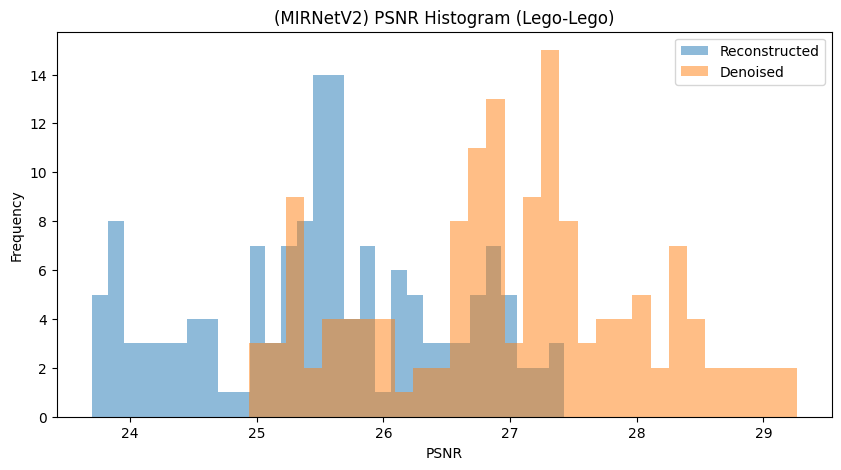

In [11]:
# plot histogram of PSNR values
plt.figure(figsize=(10, 5))
plt.hist(lego_lego_psnr_value.values(), bins=30, alpha=0.5, label='Reconstructed')
plt.hist(lego_lego_model_psnr.values(), bins=30, alpha=0.5, label='Denoised')
plt.title('(MIRNetV2) PSNR Histogram (Lego-Lego)')
plt.xlabel('PSNR') 
plt.ylabel('Frequency')
plt.legend()
plt.show()

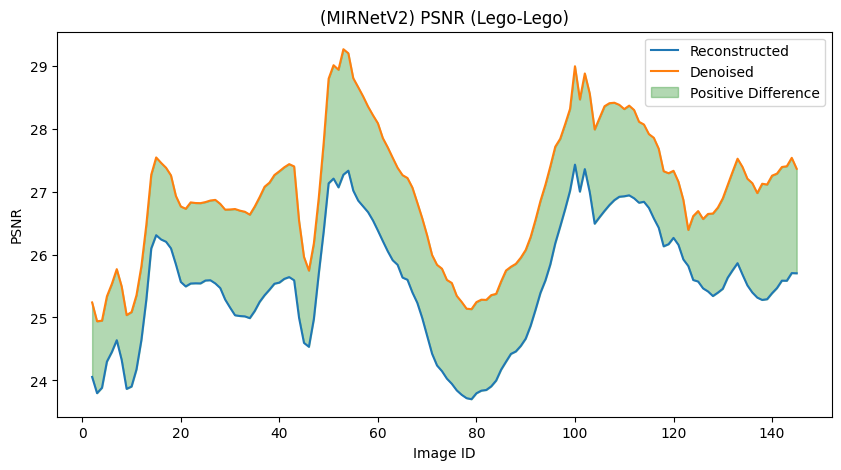

In [12]:
import numpy as np
# Convert values to numpy arrays
psnr_values = np.array(list(lego_lego_psnr_value.values()))
model_psnr_values = np.array(list(lego_lego_model_psnr.values()))

# Plot the figure
plt.figure(figsize=(10, 5))
plt.plot(lego_lego_psnr_value.keys(), psnr_values, label='Reconstructed')
plt.plot(lego_lego_model_psnr.keys(), model_psnr_values, label='Denoised')
plt.fill_between(lego_lego_psnr_value.keys(), psnr_values, model_psnr_values, color='green', alpha=0.3)
plt.title('(MIRNetV2) PSNR (Lego-Lego)')
plt.xlabel('Image ID')
plt.ylabel('PSNR')
plt.legend()
# add legend to the filled area with green for positive difference and red for negative difference
plt.legend(['Reconstructed', 'Denoised', 'Positive Difference', 'Negative Difference'], loc='upper right')
plt.show()

In [13]:
# show the percentage of images that have higher PSNR in the denoised images
higher_psnr = [1 for i in range(2, 146) if lego_lego_model_psnr[i] > lego_lego_psnr_value[i]]
print(f'Percentage of images with higher PSNR in the denoised images: {len(higher_psnr) / 1.44}%')


Percentage of images with higher PSNR in the denoised images: 100.0%


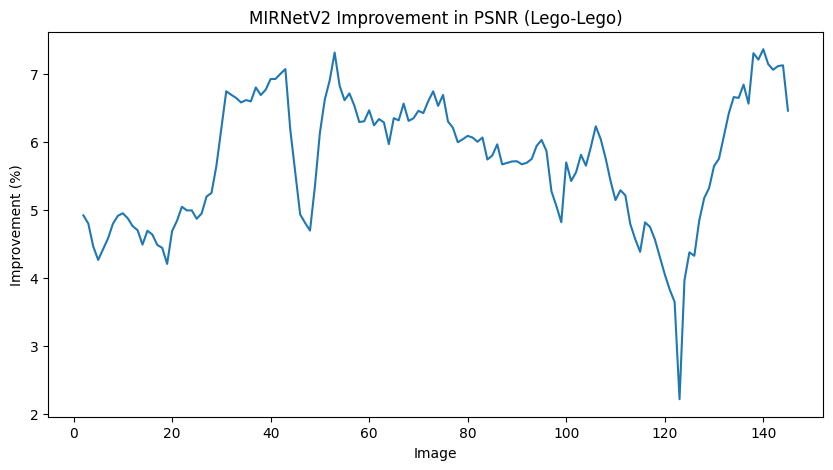

In [14]:
# plot the improvement in PSNR for each image in percentage
improvement = [(lego_lego_model_psnr[i] - lego_lego_psnr_value[i]) / lego_lego_psnr_value[i] * 100 for i in range(2, 146)]
plt.figure(figsize=(10, 5))
plt.plot(range(2, 146), improvement)
plt.title('MIRNetV2 Improvement in PSNR (Lego-Lego)')
plt.xlabel('Image')
plt.ylabel('Improvement (%)')
plt.show()

# Loss and statistics

In [15]:
# # read the txt file in MirNet5k.txt
# log_file = "./MirNet5k.txt"

# # extract the epoche number and loss value with regex from the log Epoch [3999/5000], Loss: 0.0021 and save it in a dictionary
# import re
# losses = {}
# with open(log_file, 'r') as file:
#     for line in file:
#         match = re.search(r'Epoch \[(\d+)/5000\], Loss: (\d+\.\d+)', line)
#         if match:
#             epoch, loss = match.groups()
#             losses[int(epoch)] = float(loss)

# # plot the loss values
# plt.figure(figsize=(10, 5))
# plt.plot(losses.keys(), losses.values())
# plt.title('MIRNetV2 Loss (Lego-Lego)')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.show()

In [16]:
# # zoom into the first 40 epochs
# plt.figure(figsize=(10, 5))
# plt.plot(list(losses.keys())[:40], list(losses.values())[:40])
# plt.title('MIRNetV2 Loss Zoomed In')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.show()


# LPIPS 

In [17]:
import lpips
# Calculate the lpips loss
loss_fn_lpips = lpips.LPIPS(net='alex') # best forward scores
loss_fn_lpips.cuda()

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\aligh\anaconda3\envs\nerfstudio\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\aligh\anaconda3\envs\nerfstudio\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\aligh\anaconda3\envs\nerfstudio\lib\site-packages\lpips\weights\v0.1\alex.pth


LPIPS(
  (scaling_layer): ScalingLayer()
  (net): alexnet(
    (slice1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
    )
    (slice2): Sequential(
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
    )
    (slice3): Sequential(
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
    )
    (slice4): Sequential(
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
    )
    (slice5): Sequential(
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
    )
  )
  (lin0): NetLinLayer(
    (model): Sequential(
      (0): D

In [18]:
def calculate_LPIPS(original_path, reconstructed_path, resize_transform=False):
    # Read the original and reconstructed images
    original = cv2.imread(original_path, cv2.IMREAD_UNCHANGED)
    reconstructed = cv2.imread(reconstructed_path, cv2.IMREAD_UNCHANGED)
    
    if resize_transform:
        original = cv2.resize(original, (398, 398))

    img0 = lpips.im2tensor(original)
    img1 = lpips.im2tensor(reconstructed)

    img0 = img0.cuda()
    img1 = img1.cuda()

    original_lpips = loss_fn_lpips(img0, img1)

    original_lpips = round(float(original_lpips), 3)

    return original_lpips

In [19]:
# calculate the LPIPS between the original and reconstructed images
lego_lego_lpips_value = {}
for i in range(2, 146):
    original_path = os.path.join(origial_images, f'{i}.png')
    reconstructed_path = os.path.join(reconstructed_images, f'{i}.png')
    lego_lego_lpips_value[i] = calculate_LPIPS(original_path, reconstructed_path)


In [20]:
# calculate the LPIPS between the original and denoised images
lego_lego_model_lpips = {}
for i in range(2, 146):
    original_path = os.path.join(origial_images, f'{i}.png')
    denoised_path = os.path.join(denoised_images, f'{i}.png')
    lego_lego_model_lpips[i] = calculate_LPIPS(original_path, denoised_path, True)

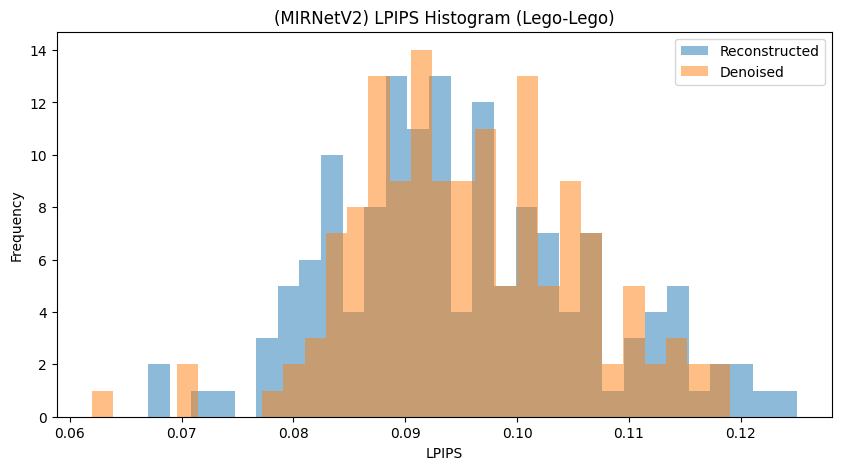

In [21]:
# plot histogram of LPIPS values
plt.figure(figsize=(10, 5))
plt.hist(lego_lego_lpips_value.values(), bins=30, alpha=0.5, label='Reconstructed')
plt.hist(lego_lego_model_lpips.values(), bins=30, alpha=0.5, label='Denoised')
plt.title('(MIRNetV2) LPIPS Histogram (Lego-Lego)')
plt.xlabel('LPIPS')
plt.ylabel('Frequency')
plt.legend()
plt.show()


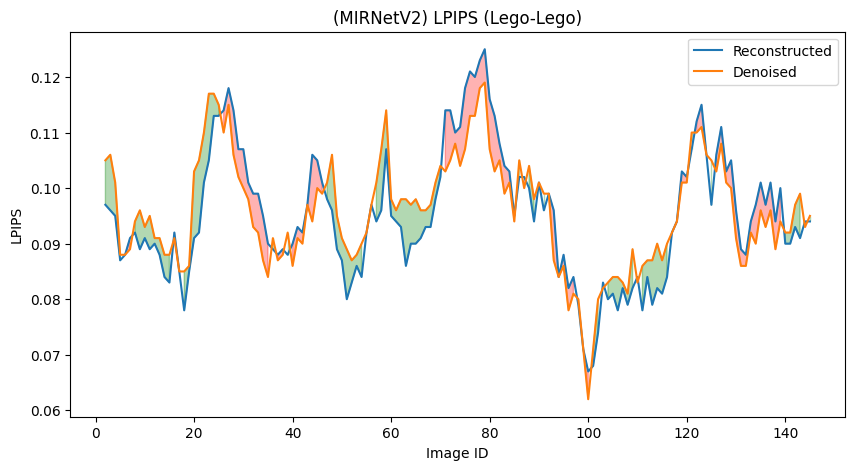

In [22]:
import numpy as np
# Convert values to numpy arrays
lego_lego_lpips_values = np.array(list(lego_lego_lpips_value.values()))
lego_lego_model_lpips_values = np.array(list(lego_lego_model_lpips.values()))

# Plot the figure
plt.figure(figsize=(10, 5))
plt.plot(lego_lego_lpips_value.keys(), lego_lego_lpips_values, label='Reconstructed')
plt.plot(lego_lego_model_lpips.keys(), lego_lego_model_lpips_values, label='Denoised')
plt.fill_between(lego_lego_lpips_value.keys(), lego_lego_lpips_values, lego_lego_model_lpips_values, where=lego_lego_model_lpips_values > lego_lego_lpips_values, color='green', alpha=0.3)
plt.fill_between(lego_lego_lpips_value.keys(), lego_lego_lpips_values, lego_lego_model_lpips_values, where=lego_lego_model_lpips_values <= lego_lego_lpips_values, color='red', alpha=0.3)
plt.title('(MIRNetV2) LPIPS (Lego-Lego)')
plt.xlabel('Image ID')
plt.ylabel('LPIPS')
plt.legend()
plt.show()

# Setup #2
Train: Ruins2 <br>
Test: Ruins2

# Real Scences data

In [23]:
import os
import re


In [24]:
# origial image path
folder_path = 'C:/Users/aligh/OneDrive/Desktop/nds_test'
real_image_lists = {'nds': [], 'original': [], 'restored': []}

for filename in os.listdir(folder_path):
    match = re.match(r'(.+?)\.jpg_(nds|original|restored)\.jpg', filename)
    if match:
        image_name, category = match.groups()
        real_image_lists[category].append(image_name)

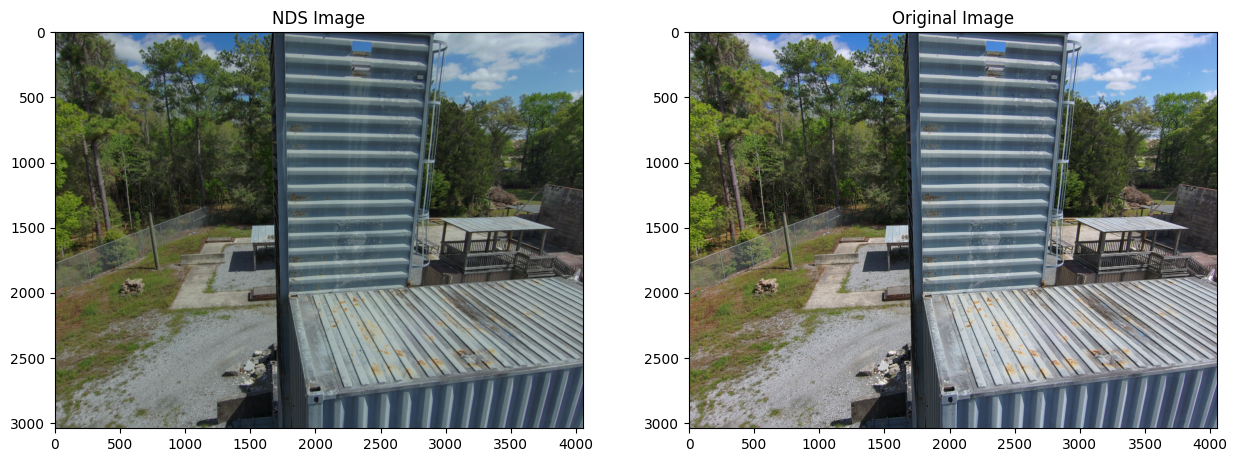

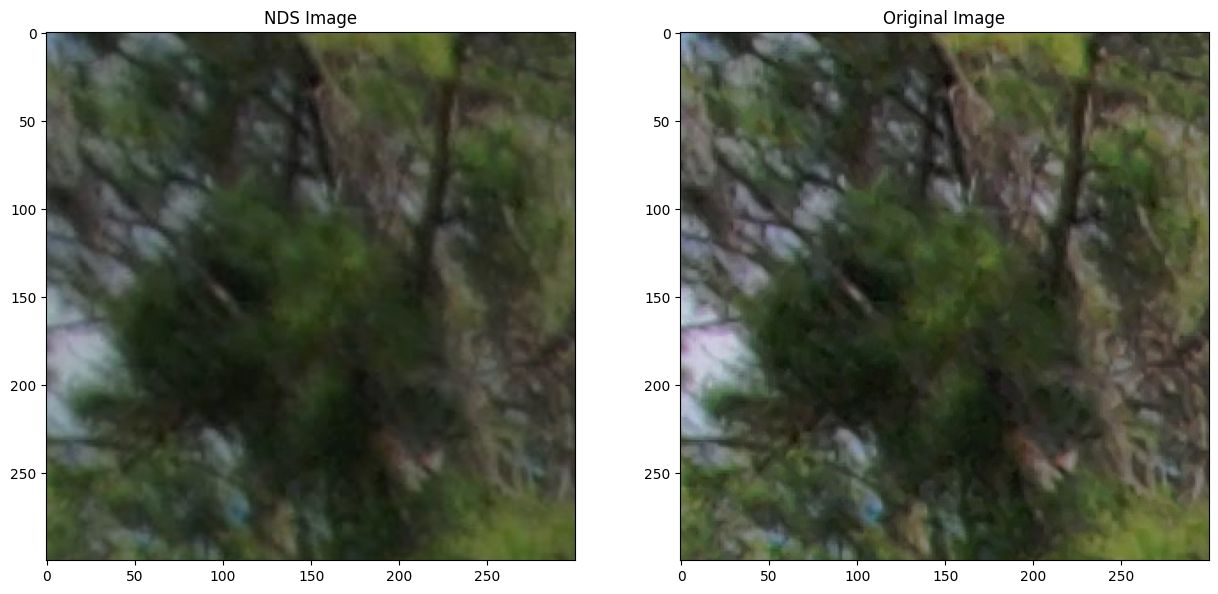

In [25]:
# show 1 sample from each category
sample_nds = cv2.imread(os.path.join("D:/CentraleSupelec/BDRP/Code/CS-BDRP-nerf/noiseDegradation/nds_outputLong2/", f'0b7a15ea9d64445fa040730dabe63ce4.jpg'))
sample_original = cv2.imread(os.path.join("D:/CentraleSupelec/BDRP/Code/CS-BDRP-nerf/dataset/ruins2/images/", f'0b7a15ea9d64445fa040730dabe63ce4.jpg'))
sample_restored = cv2.imread(os.path.join(folder_path, f'0b7a15ea9d64445fa040730dabe63ce4.jpg_restored.jpg'))
plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.title('NDS Image')
plt.imshow(cv2.cvtColor(sample_nds, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(sample_original, cv2.COLOR_BGR2RGB))
# plt.subplot(133)
# plt.title('Restored Image')
# plt.imshow(cv2.cvtColor(sample_restored, cv2.COLOR_BGR2RGB))
plt.show()

# show 1 sample with focuse of left upper corner with 100x100 size
sample_nds = cv2.imread(os.path.join("D:/CentraleSupelec/BDRP/Code/CS-BDRP-nerf/noiseDegradation/nds_outputLong2/", f'0b7a15ea9d64445fa040730dabe63ce4.jpg'))
sample_original = cv2.imread(os.path.join("D:/CentraleSupelec/BDRP/Code/CS-BDRP-nerf/dataset/ruins2/images/", f'0b7a15ea9d64445fa040730dabe63ce4.jpg'))
sample_restored = cv2.imread(os.path.join(folder_path, f'0b7a15ea9d64445fa040730dabe63ce4.jpg_restored.jpg'))
plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.title('NDS Image')
plt.imshow(cv2.cvtColor(sample_nds[:300, :300], cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(sample_original[:300, :300], cv2.COLOR_BGR2RGB))
# plt.subplot(133)
# plt.title('Restored Image')
# plt.imshow(cv2.cvtColor(sample_restored[:300, :300], cv2.COLOR_BGR2RGB))
plt.show()

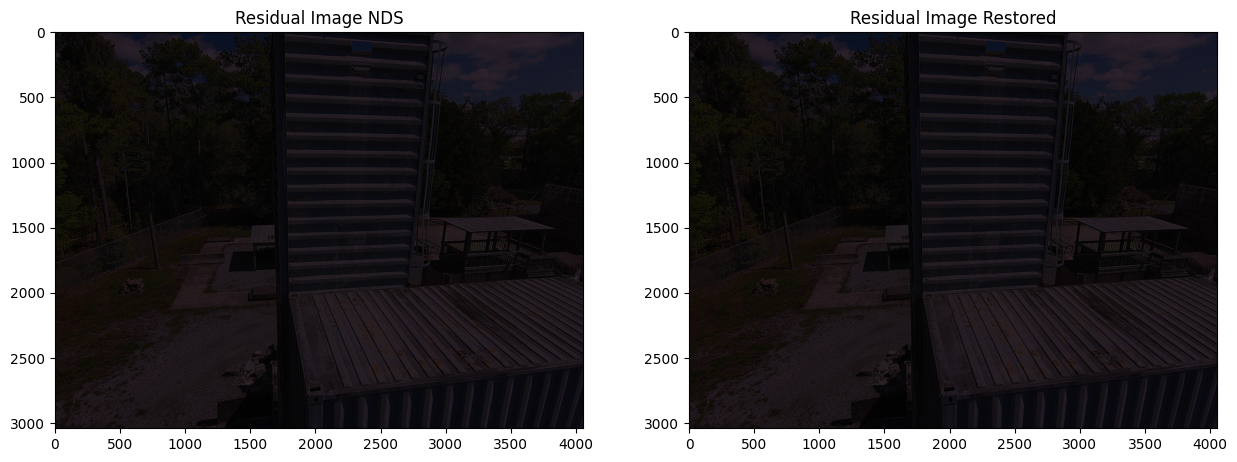

In [26]:
# show the residual images for original-nds and original-restored
residual_image_nds = cv2.absdiff(sample_original, sample_nds)
residual_image_restored = cv2.absdiff(sample_original, sample_nds)
plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.title('Residual Image NDS')
plt.imshow(cv2.cvtColor(residual_image_nds, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.title('Residual Image Restored')
plt.imshow(cv2.cvtColor(residual_image_restored, cv2.COLOR_BGR2RGB))
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


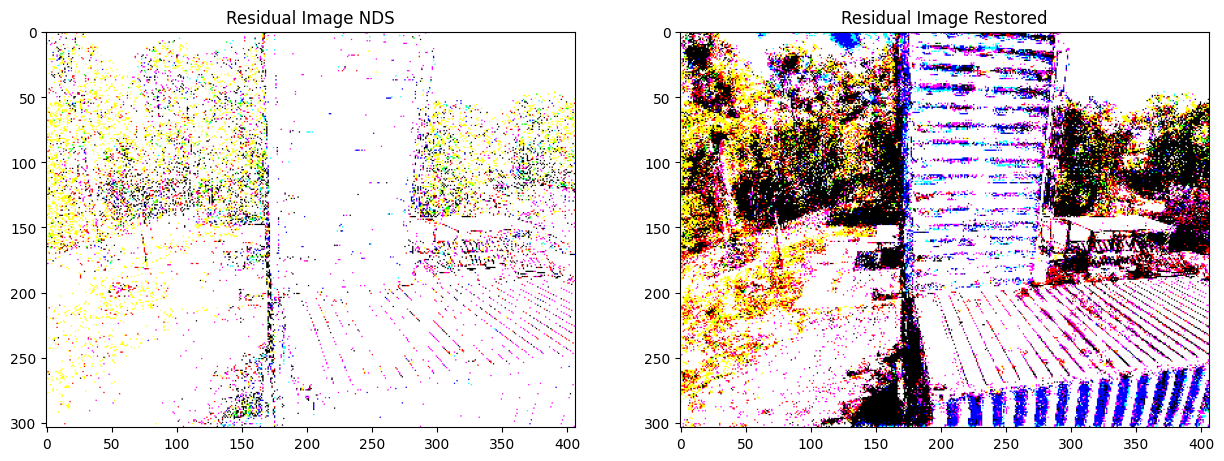

In [27]:
# calculate residual images for sample image 
residual_image_nds = calculate_residual(os.path.join(folder_path, '0b7a15ea9d64445fa040730dabe63ce4.jpg_original.jpg'), os.path.join(folder_path, '0b7a15ea9d64445fa040730dabe63ce4.jpg_nds.jpg'))
residual_image_restored = calculate_residual(os.path.join(folder_path, '0b7a15ea9d64445fa040730dabe63ce4.jpg_original.jpg'), os.path.join(folder_path, '0b7a15ea9d64445fa040730dabe63ce4.jpg_restored.jpg'))
# show the residual images
plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.title('Residual Image NDS')
plt.imshow(cv2.cvtColor(residual_image_nds, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.title('Residual Image Restored')
plt.imshow(cv2.cvtColor(residual_image_restored, cv2.COLOR_BGR2RGB))
plt.show()


In [28]:
# calculate the PSNR between the original group and the nds group
real_real_nds_psnr = {}
for image in real_image_lists['nds']:
    if not os.path.exists(os.path.join(folder_path, f'{image}.jpg_original.jpg')) or not os.path.exists(os.path.join(folder_path, f'{image}.jpg_nds.jpg')) or not os.path.exists(os.path.join(folder_path, f'{image}.jpg_restored.jpg')):
        continue
    original_path = os.path.join(folder_path, f'{image}.jpg_original.jpg')
    nds_path = os.path.join(folder_path, f'{image}.jpg_nds.jpg')
    original = cv2.imread(original_path, cv2.IMREAD_UNCHANGED)
    nds = cv2.imread(nds_path, cv2.IMREAD_UNCHANGED)
    real_real_nds_psnr[image] = calculate_psnr(original, nds)
    

In [29]:
# calculate the PSNR between the original group and the restored group
real_real_restored_psnr = {}
for image in real_image_lists['restored']:
    if not os.path.exists(os.path.join(folder_path, f'{image}.jpg_original.jpg')) or not os.path.exists(os.path.join(folder_path, f'{image}.jpg_nds.jpg')) or not os.path.exists(os.path.join(folder_path, f'{image}.jpg_restored.jpg')):
        continue
    original_path = os.path.join(folder_path, f'{image}.jpg_original.jpg')
    restored_path = os.path.join(folder_path, f'{image}.jpg_restored.jpg')
    original = cv2.imread(original_path, cv2.IMREAD_UNCHANGED)
    restored = cv2.imread(restored_path, cv2.IMREAD_UNCHANGED)
    real_real_restored_psnr[image] = calculate_psnr(original, restored)

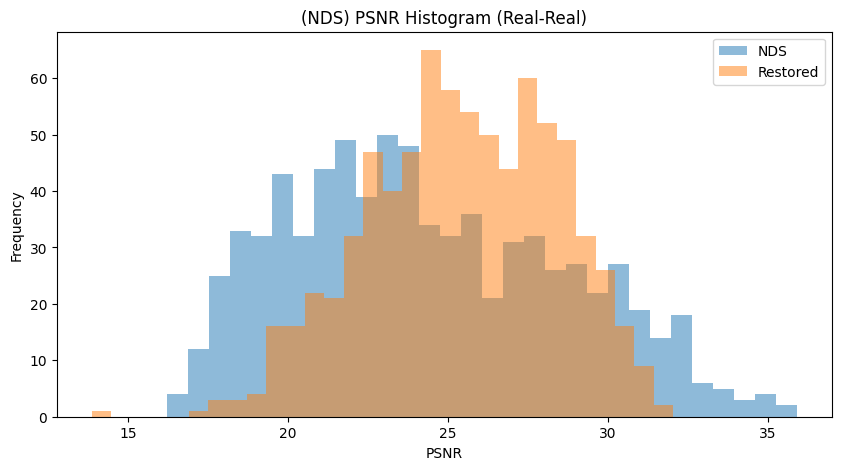

In [30]:
# plot histogram of PSNR values
plt.figure(figsize=(10, 5))
plt.hist(real_real_nds_psnr.values(), bins=30, alpha=0.5, label='NDS')
plt.hist(real_real_restored_psnr.values(), bins=30, alpha=0.5, label='Restored')
plt.title('(NDS) PSNR Histogram (Real-Real)')
plt.xlabel('PSNR')
plt.ylabel('Frequency')
plt.legend()
plt.show()

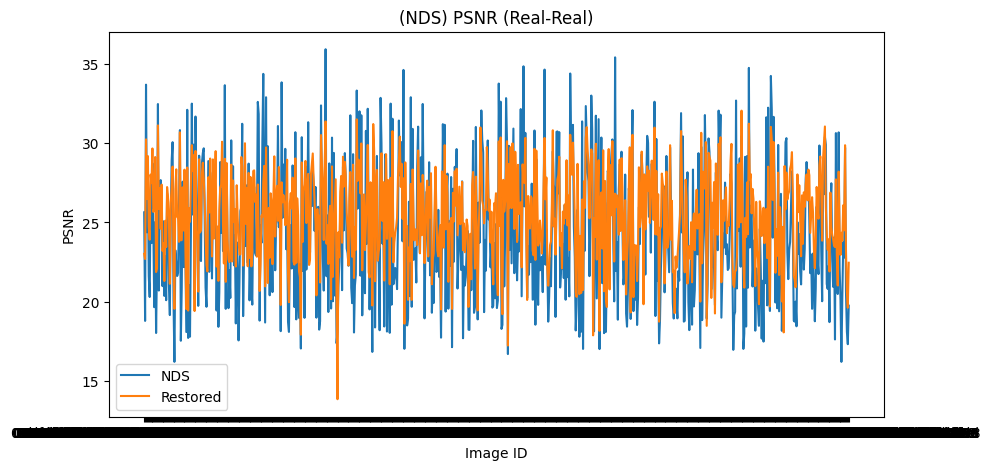

In [31]:
# for each image draw the difference between the original and nds images in pnsr
plt.figure(figsize=(10, 5))
plt.plot(real_real_nds_psnr.keys(), real_real_nds_psnr.values(), label='NDS')
plt.plot(real_real_restored_psnr.keys(), real_real_restored_psnr.values(), label='Restored')
plt.title('(NDS) PSNR (Real-Real)')
plt.xlabel('Image ID')
plt.ylabel('PSNR')
plt.legend()
plt.show()


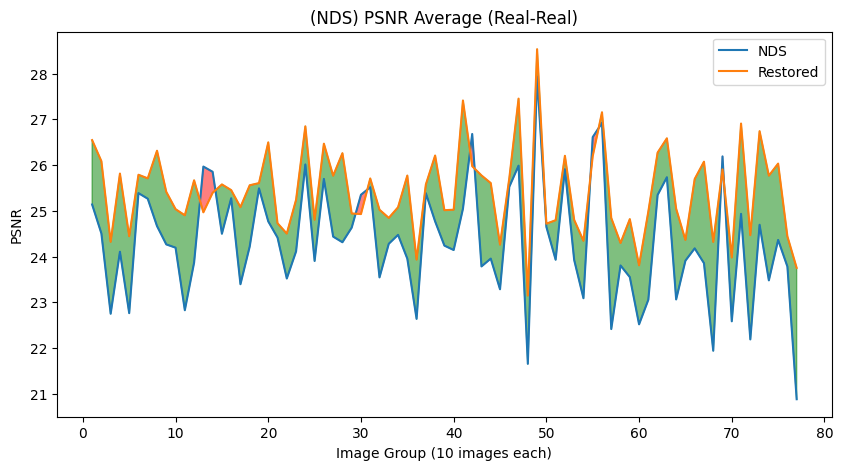

In [32]:
real_real_nds_psnr_avg = [sum(list(real_real_nds_psnr.values())[i:i+10]) / 10 for i in range(0, len(real_real_nds_psnr), 10)]
real_real_restored_psnr_avg = [sum(list(real_real_restored_psnr.values())[i:i+10]) / 10 for i in range(0, len(real_real_restored_psnr), 10)]
# exclude the last group if it has less than 10 images
if len(real_real_nds_psnr) % 10 != 0:
    real_real_nds_psnr_avg = real_real_nds_psnr_avg[:-1]
    real_real_restored_psnr_avg = real_real_restored_psnr_avg[:-1]

x_axis = range(1, len(real_real_nds_psnr_avg) + 1)
y1 = real_real_nds_psnr_avg
y2 = real_real_restored_psnr_avg

# Adjust the size of the 'where' argument to match the size of 'x_axis'
where = np.array(real_real_nds_psnr_avg) <= np.array(real_real_restored_psnr_avg)

plt.figure(figsize=(10, 5))
plt.plot(x_axis, y1, label='NDS')
plt.plot(x_axis, y2, label='Restored')
plt.fill_between(x_axis, y1, y2, where=where, interpolate=True, color='green', alpha=0.5)
plt.fill_between(x_axis, y1, y2, where=~where, interpolate=True, color='red', alpha=0.5)
plt.title('(NDS) PSNR Average (Real-Real)')
plt.xlabel('Image Group (10 images each)')
plt.ylabel('PSNR')
plt.legend()
plt.show()

In [33]:
# calculate the LPIPS between the original and nds images
real_real_nds_lpips = {}
for image in real_image_lists['nds']:
    # check if the images exists original and nds and restored
    if not os.path.exists(os.path.join(folder_path, f'{image}.jpg_original.jpg')) or not os.path.exists(os.path.join(folder_path, f'{image}.jpg_nds.jpg')) or not os.path.exists(os.path.join(folder_path, f'{image}.jpg_restored.jpg')):
        continue
    original_path = os.path.join(folder_path, f'{image}.jpg_original.jpg')
    nds_path = os.path.join(folder_path, f'{image}.jpg_nds.jpg')
    real_real_nds_lpips[image] = calculate_LPIPS(original_path, nds_path)

In [34]:
# calculate the LPIPS between the original and restored images
real_real_restored_lpips = {}
for image in real_image_lists['restored']:
    if not os.path.exists(os.path.join(folder_path, f'{image}.jpg_original.jpg')) or not os.path.exists(os.path.join(folder_path, f'{image}.jpg_nds.jpg')) or not os.path.exists(os.path.join(folder_path, f'{image}.jpg_restored.jpg')):
        continue
    original_path = os.path.join(folder_path, f'{image}.jpg_original.jpg')
    restored_path = os.path.join(folder_path, f'{image}.jpg_restored.jpg')
    real_real_restored_lpips[image] = calculate_LPIPS(original_path, restored_path)
    

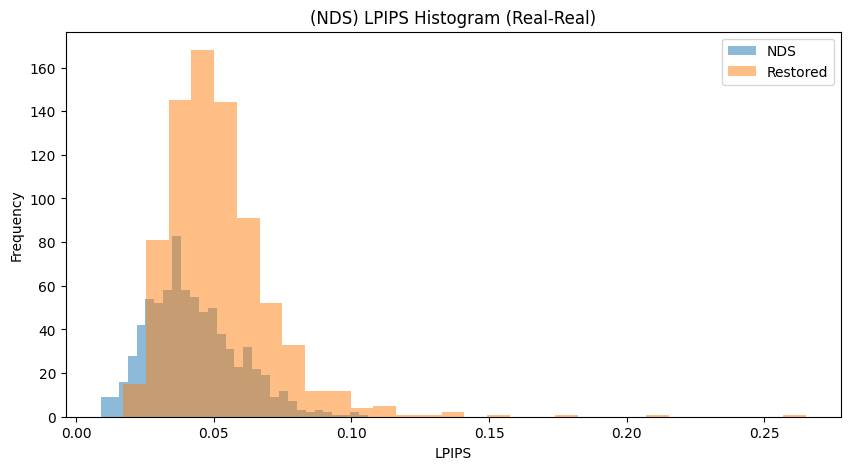

In [35]:
# plot histogram of LPIPS values
plt.figure(figsize=(10, 5))
plt.hist(real_real_nds_lpips.values(), bins=30, alpha=0.5, label='NDS')
plt.hist(real_real_restored_lpips.values(), bins=30, alpha=0.5, label='Restored')
plt.title('(NDS) LPIPS Histogram (Real-Real)')
plt.xlabel('LPIPS')
plt.ylabel('Frequency')
plt.legend()
plt.show()


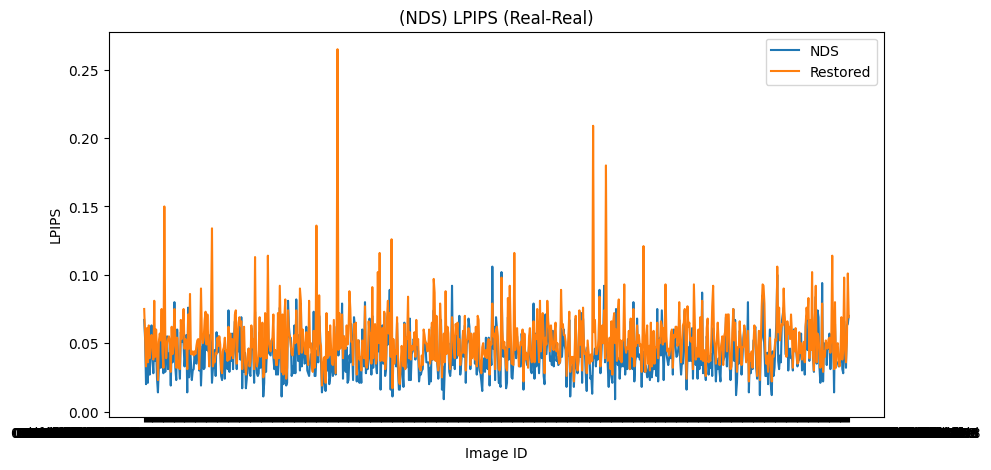

In [36]:
# for each image draw the difference between the original and nds images in LPIPS
plt.figure(figsize=(10, 5))
plt.plot(real_real_nds_lpips.keys(), real_real_nds_lpips.values(), label='NDS')
plt.plot(real_real_restored_lpips.keys(), real_real_restored_lpips.values(), label='Restored')
plt.title('(NDS) LPIPS (Real-Real)')
plt.xlabel('Image ID')
plt.ylabel('LPIPS')
plt.legend()
plt.show()


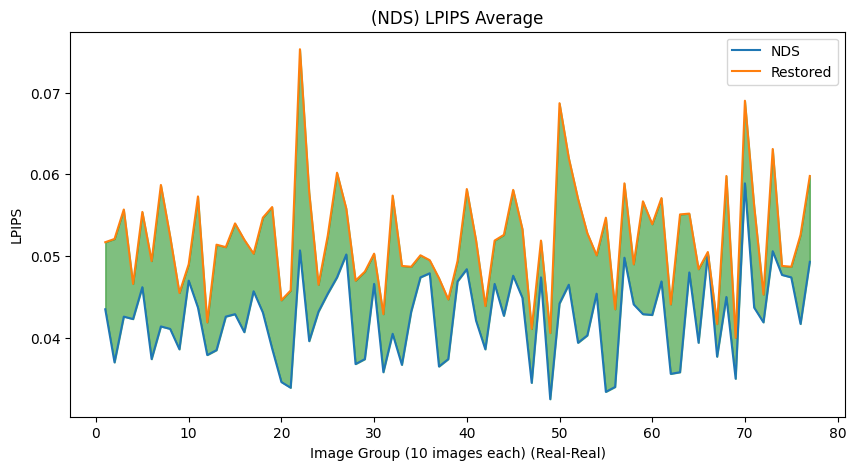

In [37]:
# show the average of LPIPS for each group of 10 images
real_real_nds_lpips_avg = [sum(list(real_real_nds_lpips.values())[i:i+10]) / 10 for i in range(0, len(real_real_nds_lpips), 10)]
real_real_restored_lpips_avg = [sum(list(real_real_restored_lpips.values())[i:i+10]) / 10 for i in range(0, len(real_real_restored_lpips), 10)]
# exclude the last group if it has less than 10 images
if len(real_real_nds_lpips) % 10 != 0:
    real_real_nds_lpips_avg = real_real_nds_lpips_avg[:-1]
    real_real_restored_lpips_avg = real_real_restored_lpips_avg[:-1]

x_axis = range(1, len(real_real_nds_lpips_avg) + 1)
y1 = real_real_nds_lpips_avg
y2 = real_real_restored_lpips_avg

# Adjust the size of the 'where' argument to match the size of 'x_axis'
where = np.array(real_real_nds_lpips_avg) <= np.array(real_real_restored_lpips_avg)

plt.figure(figsize=(10, 5))
plt.plot(x_axis, y1, label='NDS')
plt.plot(x_axis, y2, label='Restored')
plt.fill_between(x_axis, y1, y2, where=where, interpolate=True, color='green', alpha=0.5)
plt.fill_between(x_axis, y1, y2, where=~np.array(where), interpolate=True, color='red', alpha=0.5)
plt.title('(NDS) LPIPS Average')
plt.xlabel('Image Group (10 images each) (Real-Real)')
plt.ylabel('LPIPS')
plt.legend()
plt.show()

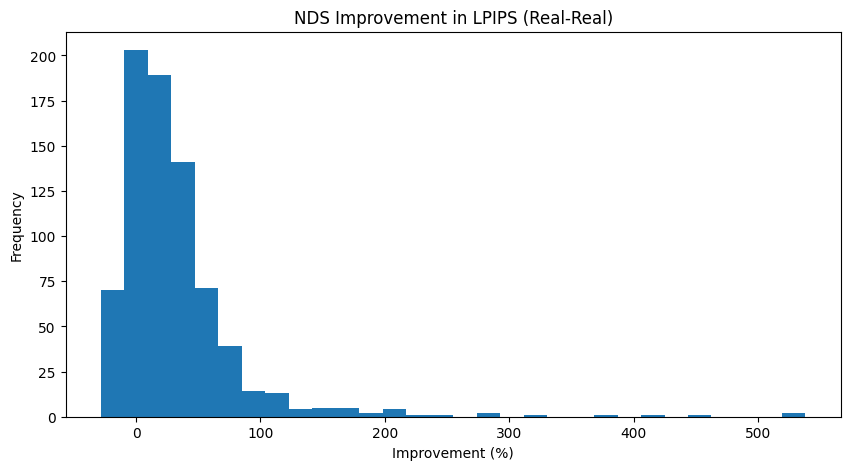

770
604
145


In [38]:
# show the histogram of the improvmentnt percentace in lPIPS
improvement = [(real_real_restored_lpips[i] - real_real_nds_lpips[i]) / real_real_nds_lpips[i] * 100 for i in real_real_nds_lpips.keys()]
# ignore values less than 100% as they are negative improvement
improvement = [i for i in improvement if i > -100]

plt.figure(figsize=(10, 5))
plt.hist(improvement, bins=30)
plt.title('NDS Improvement in LPIPS (Real-Real)')
plt.xlabel('Improvement (%)')
plt.ylabel('Frequency')
plt.show()
print(len(improvement))
# number of images with positive improvement
print(len([i for i in improvement if i > 0]))
# number of images with negative improvement
print(len([i for i in improvement if i < 0]))



# Setup #3
train: Ruins2 <br>
Test: Lego

# Lego Dataset using  Real scence model fine tunued

In [39]:
# origial image path
folder_path = 'C:/Users/aligh/OneDrive/Desktop/nds_test/LegoData'
real_image_lists = {'nds': [], 'original': [], 'restored': []}

for filename in os.listdir(folder_path):
    match = re.match(r'(.+?)\.png_(nds|original|restored)\.png', filename)
    if match:
        image_name, category = match.groups()
        real_image_lists[category].append(image_name)

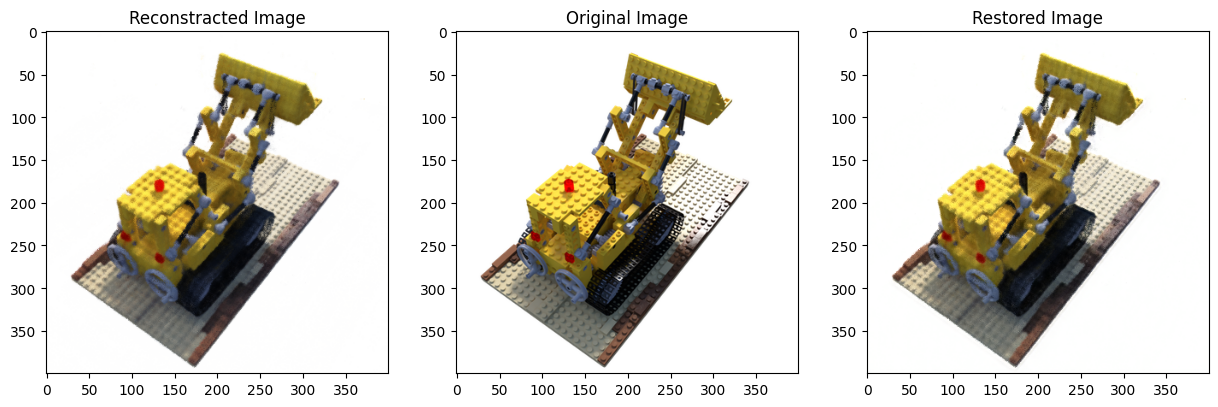

In [40]:
# show 1 sample from each category
sample_nds = cv2.imread(os.path.join(folder_path, f'{real_image_lists["nds"][0]}.png_nds.png'))
sample_original = cv2.imread(os.path.join(folder_path, f'{real_image_lists["original"][0]}.png_original.png'))
sample_restored = cv2.imread(os.path.join(folder_path, f'{real_image_lists["restored"][0]}.png_restored.png'))
plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.title('Reconstracted Image')
plt.imshow(cv2.cvtColor(sample_nds, cv2.COLOR_BGR2RGB))
plt.subplot(132)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(sample_original, cv2.COLOR_BGR2RGB))
plt.subplot(133)
plt.title('Restored Image')
plt.imshow(cv2.cvtColor(sample_restored, cv2.COLOR_BGR2RGB))
plt.show()

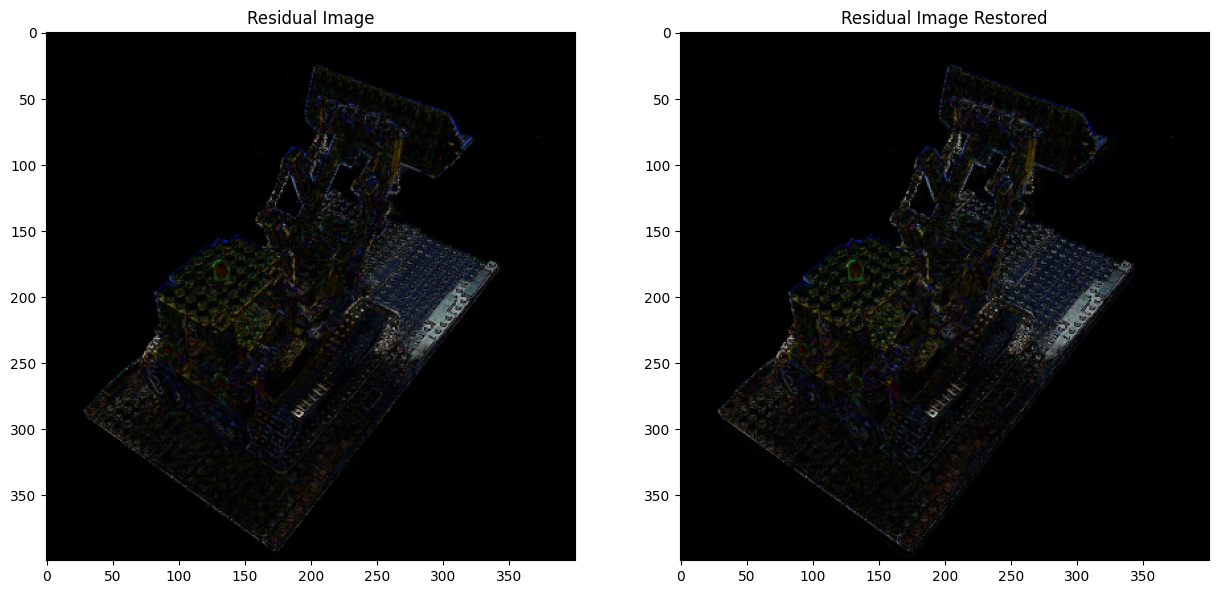

In [41]:
# calcualte the residual images for original-nds and original-restored sample images
residual_image_nds = cv2.absdiff(sample_original, sample_nds)
residual_image_restored = cv2.absdiff(sample_original, sample_restored)
plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.title('Residual Image')
plt.imshow(cv2.cvtColor(residual_image_nds, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.title('Residual Image Restored')
plt.imshow(cv2.cvtColor(residual_image_restored, cv2.COLOR_BGR2RGB))
plt.show()


In [42]:
# calculate the PSNR between the original group and the nds group
real_lego_nds_psnr_lego = {}
for image in real_image_lists['nds']:
    original_path = os.path.join(folder_path, f'{image}.png_original.png')
    nds_path = os.path.join(folder_path, f'{image}.png_nds.png')
    original = cv2.imread(original_path, cv2.IMREAD_UNCHANGED)
    nds = cv2.imread(nds_path, cv2.IMREAD_UNCHANGED)
    real_lego_nds_psnr_lego[image] = calculate_psnr(original, nds)

In [43]:
# calculate the PSNR between the original group and the restored group
real_lego_restored_psnr_lego = {}
for image in real_image_lists['restored']:
    original_path = os.path.join(folder_path, f'{image}.png_original.png')
    restored_path = os.path.join(folder_path, f'{image}.png_restored.png')
    original = cv2.imread(original_path, cv2.IMREAD_UNCHANGED)
    restored = cv2.imread(restored_path, cv2.IMREAD_UNCHANGED)
    real_lego_restored_psnr_lego[image] = calculate_psnr(original, restored)
    

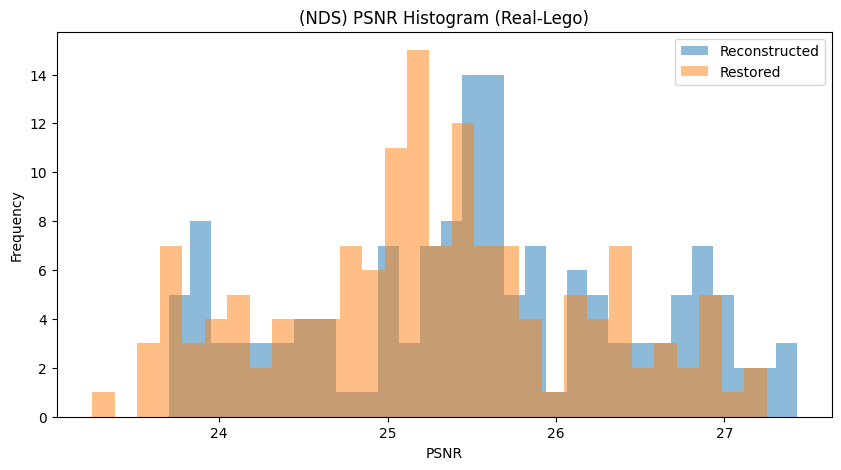

In [44]:
# plot histogram of PSNR values
plt.figure(figsize=(10, 5))
plt.hist(real_lego_nds_psnr_lego.values(), bins=30, alpha=0.5, label='Reconstructed')
plt.hist(real_lego_restored_psnr_lego.values(), bins=30, alpha=0.5, label='Restored')
plt.title('(NDS) PSNR Histogram (Real-Lego)')
plt.xlabel('PSNR')
plt.ylabel('Frequency')
plt.legend()
plt.show()

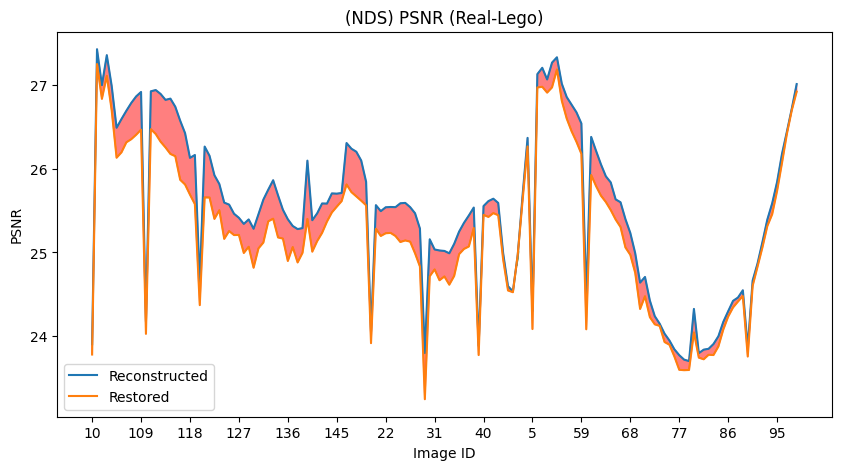

In [45]:
# for each image draw the difference between the original and nds images in pnsr
plt.figure(figsize=(10, 5))
plt.plot(real_lego_nds_psnr_lego.keys(), real_lego_nds_psnr_lego.values(), label='Reconstructed')
plt.plot(real_lego_restored_psnr_lego.keys(), real_lego_restored_psnr_lego.values(), label='Restored')
# adject the 'where' argument to match the size of the x-axis
where = np.array(list(real_lego_nds_psnr_lego.values())) <= np.array(list(real_lego_restored_psnr_lego.values()))
plt.fill_between(real_lego_nds_psnr_lego.keys(), list(real_lego_nds_psnr_lego.values()), list(real_lego_restored_psnr_lego.values()), where=where, interpolate=True, color='green', alpha=0.5)
plt.fill_between(real_lego_nds_psnr_lego.keys(), list(real_lego_nds_psnr_lego.values()), list(real_lego_restored_psnr_lego.values()), where=~where, interpolate=True, color='red', alpha=0.5)
# show only the image id every 10 images
plt.xticks(list(real_lego_nds_psnr_lego.keys())[::10])
plt.title('(NDS) PSNR (Real-Lego)')
plt.xlabel('Image ID')
plt.ylabel('PSNR')
plt.legend()
plt.show()


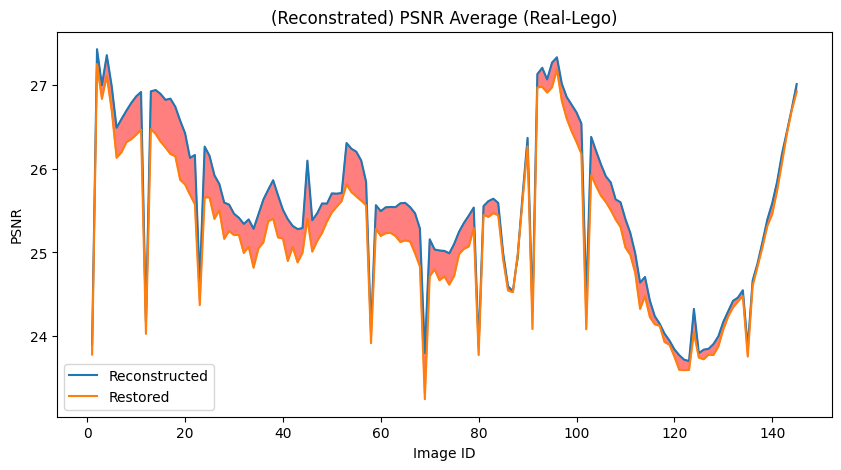

In [46]:
# show the average of PSNR for each group of 10 images
real_lego_nds_psnr_avg_lego = [sum(list(real_lego_nds_psnr_lego.values())[i:i+1]) / 1 for i in range(0, len(real_lego_nds_psnr_lego), 1)]
real_lego_restored_psnr_avg_lego = [sum(list(real_lego_restored_psnr_lego.values())[i:i+1]) / 1 for i in range(0, len(real_lego_restored_psnr_lego), 1)]
# exclude the last group if it has less than 5 images
if len(real_lego_nds_psnr_lego) % 1 != 0:
    real_lego_nds_psnr_avg_lego = real_lego_nds_psnr_avg_lego[:-1]
    real_lego_restored_psnr_avg_lego = real_lego_restored_psnr_avg_lego[:-1]

x_axis = range(1, len(real_lego_nds_psnr_avg_lego) + 1)
y1 = real_lego_nds_psnr_avg_lego
y2 = real_lego_restored_psnr_avg_lego

# Adjust the size of the 'where' argument to match the size of 'x_axis'
where = np.array(real_lego_nds_psnr_avg_lego) <= np.array(real_lego_restored_psnr_avg_lego)

plt.figure(figsize=(10, 5))
plt.plot(x_axis, y1, label='Reconstructed')
plt.plot(x_axis, y2, label='Restored')
plt.fill_between(x_axis, y1, y2, where=where, interpolate=True, color='green', alpha=0.5)
plt.fill_between(x_axis, y1, y2, where=~where, interpolate=True, color='red', alpha=0.5)
plt.title('(Reconstrated) PSNR Average (Real-Lego)')
plt.xlabel('Image ID')
plt.ylabel('PSNR')
plt.legend()
plt.show()

In [47]:
# calculate the LPIPS between the original and nds images
real_lego_nds_lpips_lego = {}
for image in real_image_lists['nds']:
    original_path = os.path.join(folder_path, f'{image}.png_original.png')
    nds_path = os.path.join(folder_path, f'{image}.png_nds.png')
    real_lego_nds_lpips_lego[image] = calculate_LPIPS(original_path, nds_path)
    

In [48]:
# calculate the LPIPS between the original and restored images
real_lego_restored_lpips_lego = {}
for image in real_image_lists['restored']:
    original_path = os.path.join(folder_path, f'{image}.png_original.png')
    restored_path = os.path.join(folder_path, f'{image}.png_restored.png')
    real_lego_restored_lpips_lego[image] = calculate_LPIPS(original_path, restored_path)
    

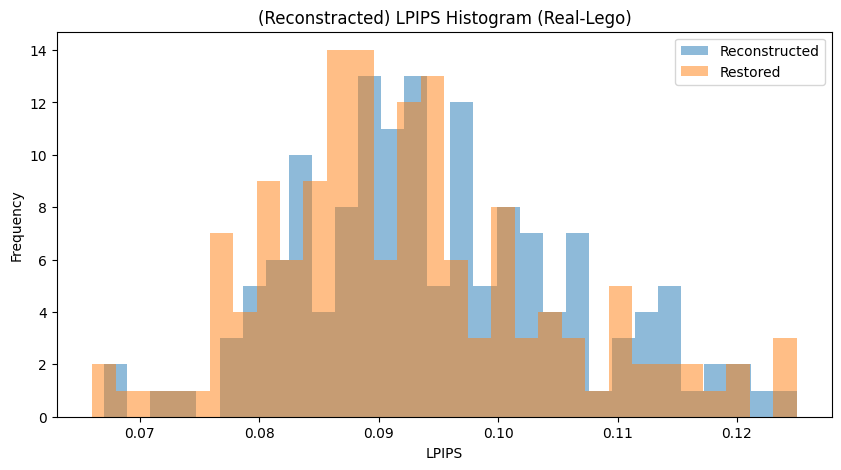

In [49]:
# plot histogram of LPIPS values
plt.figure(figsize=(10, 5))
plt.hist(real_lego_nds_lpips_lego.values(), bins=30, alpha=0.5, label='Reconstructed')
plt.hist(real_lego_restored_lpips_lego.values(), bins=30, alpha=0.5, label='Restored')
plt.title('(Reconstracted) LPIPS Histogram (Real-Lego)')
plt.xlabel('LPIPS')
plt.ylabel('Frequency')
plt.legend()
plt.show()


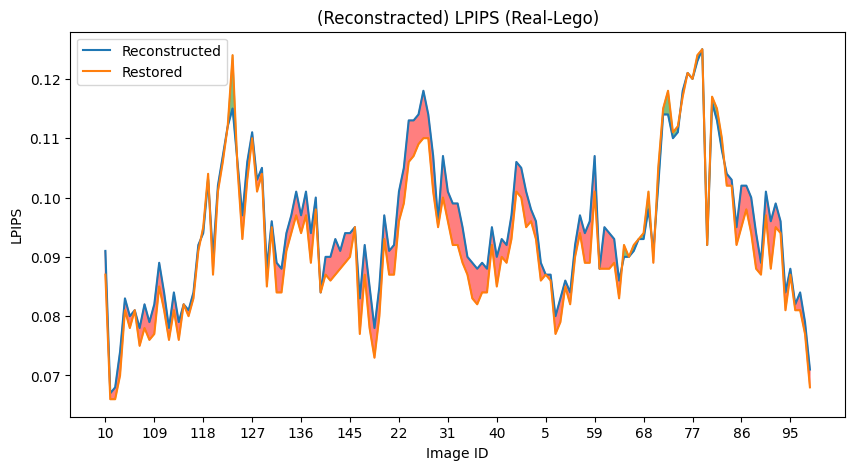

In [50]:
# for each image draw the difference between the original and nds images in LPIPS
plt.figure(figsize=(10, 5))
plt.plot(real_lego_nds_lpips_lego.keys(), real_lego_nds_lpips_lego.values(), label='Reconstructed')
plt.plot(real_lego_restored_lpips_lego.keys(), real_lego_restored_lpips_lego.values(), label='Restored')
# adjust the where argument to match the size of the x_axis
where = np.array(list(real_lego_nds_lpips_lego.values())) <= np.array(list(real_lego_restored_lpips_lego.values()))
plt.fill_between(list(real_lego_nds_lpips_lego.keys()), list(real_lego_nds_lpips_lego.values()), list(real_lego_restored_lpips_lego.values()), where=where, interpolate=True, color='green', alpha=0.5)
plt.fill_between(list(real_lego_nds_lpips_lego.keys()), list(real_lego_nds_lpips_lego.values()), list(real_lego_restored_lpips_lego.values()), where=~where, interpolate=True, color='red', alpha=0.5)

# show only every 10 pins x-axis
plt.xticks(list(real_lego_nds_lpips_lego.keys())[::10])


plt.title('(Reconstracted) LPIPS (Real-Lego)')
plt.xlabel('Image ID')
plt.ylabel('LPIPS')
plt.legend()
plt.show()

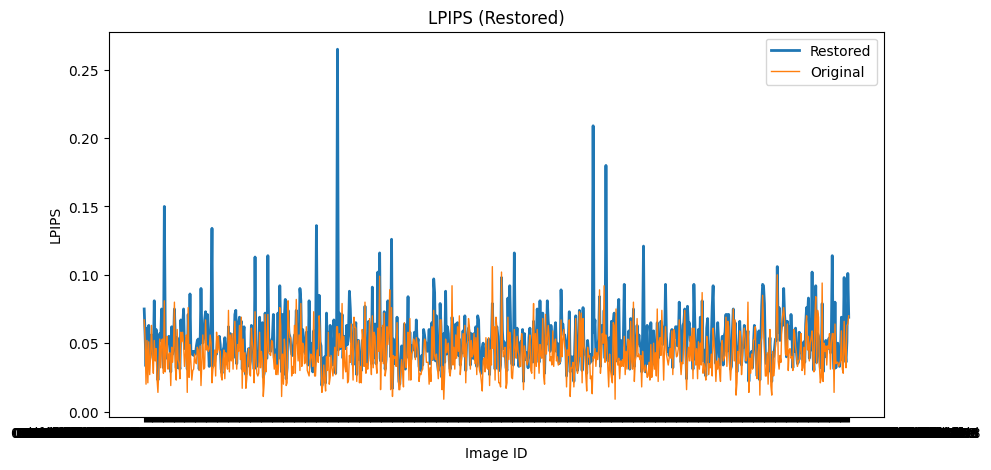

In [51]:
plt.figure(figsize=(10, 5))
plt.plot(real_real_restored_lpips.keys(), real_real_restored_lpips.values(), label='Restored', linewidth=2)
plt.plot(real_real_nds_lpips.keys(), real_real_nds_lpips.values(), label='Original', linewidth=1)
plt.title('LPIPS (Restored)')
plt.xlabel('Image ID')
plt.ylabel('LPIPS')
plt.legend()
plt.show()

In [52]:
# calculate the improvement in LPIPS for each image
improvement_lpips_per_image_real = [(real_real_restored_lpips[i] - real_real_nds_lpips[i])/ real_real_nds_lpips[i] * 100 for i in real_real_nds_lpips.keys()]

# convert the list to a dictionary
improvement_lpips_per_image_real_dict = {i: improvement_lpips_per_image_real[i] for i in range(len(improvement_lpips_per_image_real))}
# print the maximum LPIPS improvement from the restored images and its corresponding image from the original images
max_improvement_idx = max(improvement_lpips_per_image_real_dict, key=improvement_lpips_per_image_real_dict.get)


print(f'Maximum LPIPS improvement: {improvement_lpips_per_image_real[max_improvement_idx]}%')

print(f'Maximum LPIPS improvement: {improvement_lpips_per_image_real[max_improvement_idx]}%')
# find the image with that maximum improvement
max_improvement_image = list(real_real_nds_lpips.keys())[max_improvement_idx]

if max_improvement_image:
    print(f'Image ID: {max_improvement_image}')
    # old LPIPS and new LPIPS
    print(f'Old LPIPS: {real_real_nds_lpips[max_improvement_image]}')
    print(f'New LPIPS: {real_real_restored_lpips[max_improvement_image]}')
else:
    print("No image found with maximum LPIPS improvement.")


Maximum LPIPS improvement: 538.0952380952381%
Maximum LPIPS improvement: 538.0952380952381%
Image ID: 170c38417f2967f2cfd18e1db483ae7b
Old LPIPS: 0.021
New LPIPS: 0.134


# Summary

In [54]:



# average PSNR and LPIPS for setup 1
# reconstructed vs original images improvement per image 
improvement_psnr_per_image = [(lego_lego_model_psnr[i] - lego_lego_psnr_value[i]) / lego_lego_psnr_value[i] * 100 for i in range(2, 146)]
improvement_lpips_per_image = [(lego_lego_model_lpips[i] - lego_lego_lpips_value[i]) / lego_lego_lpips_value[i] * 100 for i in range(2, 146)]
# average of the improvement
improvement_psnr_avg = sum(improvement_psnr_per_image) / len(improvement_psnr_per_image)
improvement_lpips_avg = sum(improvement_lpips_per_image) / len(improvement_lpips_per_image)


# setup 2
# reconstructed vs original images improvement per image
improvement_psnr_per_image_real = [(real_real_restored_psnr[i] - real_real_nds_psnr[i]) / real_real_nds_psnr[i] * 100 for i in real_real_nds_psnr.keys()]
improvement_lpips_per_image_real = [(real_real_restored_lpips[i] - real_real_nds_lpips[i]) / real_real_nds_lpips[i] * 100 for i in real_real_nds_lpips.keys()]
# average of the improvement
improvement_psnr_avg_real = sum(improvement_psnr_per_image_real) / len(improvement_psnr_per_image_real)
improvement_lpips_avg_real = sum(improvement_lpips_per_image_real) / len(improvement_lpips_per_image_real)

# setup 3
# reconstructed vs original images improvement per image
improvement_psnr_per_image_lego = [(real_lego_restored_psnr_avg_lego[i] - real_lego_nds_psnr_avg_lego[i]) / real_lego_nds_psnr_avg_lego[i] * 100 for i in range(len(real_lego_nds_psnr_avg_lego))]
improvement_lpips_per_image_lego = [(real_lego_restored_lpips_lego[i] - real_lego_nds_lpips_lego[i]) / real_lego_nds_lpips_lego[i] * 100 for i in real_lego_nds_lpips_lego]
# average of the improvement
improvement_psnr_avg_lego = sum(improvement_psnr_per_image_lego) / len(improvement_psnr_per_image_lego)
improvement_lpips_avg_lego = sum(improvement_lpips_per_image_lego) / len(improvement_lpips_per_image_lego)


# print maximum and minimum in each setup
print(f'Maximum LPIPS Value in setup 1: {max(lego_lego_lpips_values)}')
print(f'Minimum LPIPS Value in setup 1: {min(lego_lego_lpips_values)}')
print(f'Maximum PSNR value in Step 1: {max(lego_lego_psnr_value.values())}')
print(f'Minimum PSNR value in Step 1: {min(lego_lego_psnr_value.values())}')
print(f'Maximum LPIPS Value in setup 2: {max(improvement_lpips_per_image_real)}')
print(f'Minimum LPIPS Value in setup 2: {min(improvement_lpips_per_image_real)}')
print(f'Maximum PSNR value in Step 2: {max(real_real_nds_psnr.values())}')
print(f'Minimum PSNR value in Step 2: {min(real_real_nds_psnr.values())}')
print(f'Maximum LPIPS Value in setup 3: {max(improvement_lpips_per_image_lego)}')
print(f'Minimum LPIPS Value in setup 3: {min(improvement_lpips_per_image_lego)}')
print(f'Maximum PSNR value in Step 3: {max(real_lego_nds_psnr_avg_lego)}')
print(f'Minimum PSNR value in Step 3: {min(real_lego_nds_psnr_avg_lego)}')

# print the average improvement in PSNR and LPIPS for each setup
print(f'Average Improvement in PSNR for setup 1: {improvement_psnr_avg}')
print(f'Average Improvement in LPIPS for setup 1: {improvement_lpips_avg}')
print(f'Average Improvement in PSNR for setup 2: {improvement_psnr_avg_real}')
print(f'Average Improvement in LPIPS for setup 2: {improvement_lpips_avg_real}')
print(f'Average Improvement in PSNR for setup 3: {improvement_psnr_avg_lego}')
print(f'Average Improvement in LPIPS for setup 3: {improvement_lpips_avg_lego}')


# print the minimum and maximum improvement in PSNR and LPIPS for each setup
print(f'Minimum Improvement in PSNR for setup 1: {min(improvement_psnr_per_image)}')
print(f'Maximum Improvement in PSNR for setup 1: {max(improvement_psnr_per_image)}')
print(f'Minimum Improvement in LPIPS for setup 1: {min(improvement_lpips_per_image)}')
print(f'Maximum Improvement in LPIPS for setup 1: {max(improvement_lpips_per_image)}')
print(f'Minimum Improvement in PSNR for setup 2: {min(improvement_psnr_per_image_real)}')
print(f'Maximum Improvement in PSNR for setup 2: {max(improvement_psnr_per_image_real)}')
print(f'Minimum Improvement in LPIPS for setup 2: {min(improvement_lpips_per_image_real)}')
print(f'Maximum Improvement in LPIPS for setup 2: {max(improvement_lpips_per_image_real)}')
print(f'Minimum Improvement in PSNR for setup 3: {min(improvement_psnr_per_image_lego)}')
print(f'Maximum Improvement in PSNR for setup 3: {max(improvement_psnr_per_image_lego)}')
print(f'Minimum Improvement in LPIPS for setup 3: {min(improvement_lpips_per_image_lego)}')
print(f'Maximum Improvement in LPIPS for setup 3: {max(improvement_lpips_per_image_lego)}')


# median of the improvement in PSNR and LPIPS for each setup
print(f'Median Improvement in PSNR for setup 1: {np.median(improvement_psnr_per_image)}')
print(f'Median Improvement in LPIPS for setup 1: {np.median(improvement_lpips_per_image)}')
print(f'Median Improvement in PSNR for setup 2: {np.median(improvement_psnr_per_image_real)}')
print(f'Median Improvement in LPIPS for setup 2: {np.median(improvement_lpips_per_image_real)}')
print(f'Median Improvement in PSNR for setup 3: {np.median(improvement_psnr_per_image_lego)}')
print(f'Median Improvement in LPIPS for setup 3: {np.median(improvement_lpips_per_image_lego)}')



Maximum LPIPS Value in setup 1: 0.125
Minimum LPIPS Value in setup 1: 0.067
Maximum PSNR value in Step 1: 27.42861554367543
Minimum PSNR value in Step 1: 23.701374857545304
Maximum LPIPS Value in setup 2: 538.0952380952381
Minimum LPIPS Value in setup 2: -28.26086956521739
Maximum PSNR value in Step 2: 35.91027938909733
Minimum PSNR value in Step 2: 16.223781492452115
Maximum LPIPS Value in setup 3: 7.826086956521734
Minimum LPIPS Value in setup 3: -8.333333333333341
Maximum PSNR value in Step 3: 27.42861554367543
Minimum PSNR value in Step 3: 23.701374857545304
Average Improvement in PSNR for setup 1: 5.709460962064207
Average Improvement in LPIPS for setup 1: 0.8932274604532
Average Improvement in PSNR for setup 2: 6.010181132613625
Average Improvement in LPIPS for setup 2: 31.53259367909913
Average Improvement in PSNR for setup 3: -1.1062648922546519
Average Improvement in LPIPS for setup 3: -2.973738713504589
Minimum Improvement in PSNR for setup 1: 2.2223173009856403
Maximum Impro

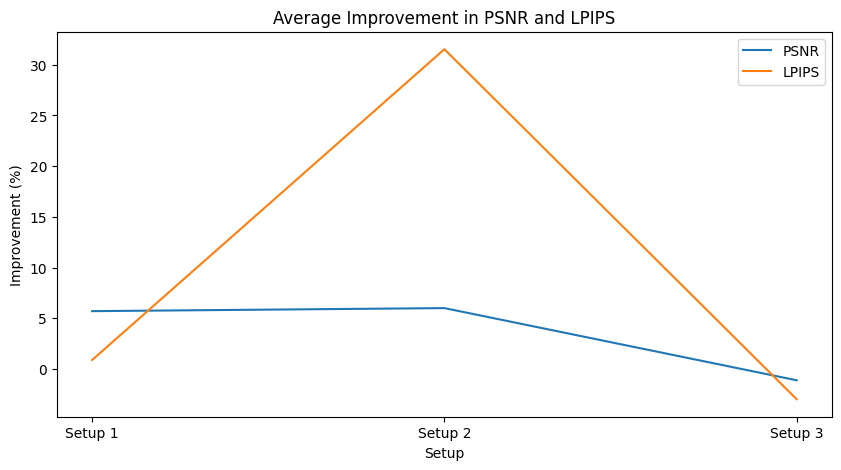

In [55]:
# plot the average improvement in PSNR and LPIPS for each setup
x = ['Setup 1', 'Setup 2', 'Setup 3']
y1 = [improvement_psnr_avg, improvement_psnr_avg_real, improvement_psnr_avg_lego]
y2 = [improvement_lpips_avg, improvement_lpips_avg_real, improvement_lpips_avg_lego]


plt.figure(figsize=(10, 5))
plt.plot(x, y1, label='PSNR')
plt.plot(x, y2, label='LPIPS')
plt.title('Average Improvement in PSNR and LPIPS')
plt.xlabel('Setup')
plt.ylabel('Improvement (%)')
plt.legend()
plt.show()

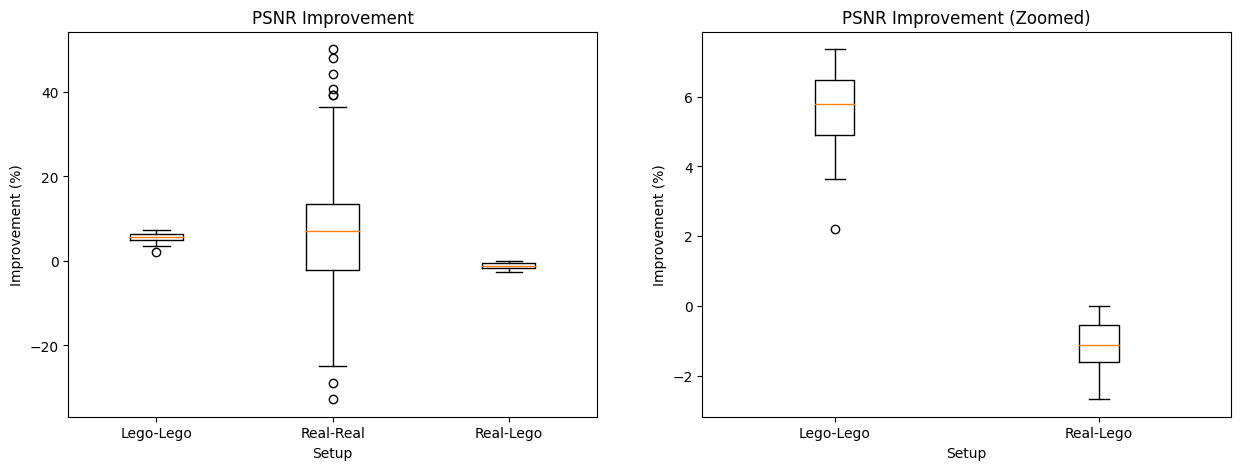

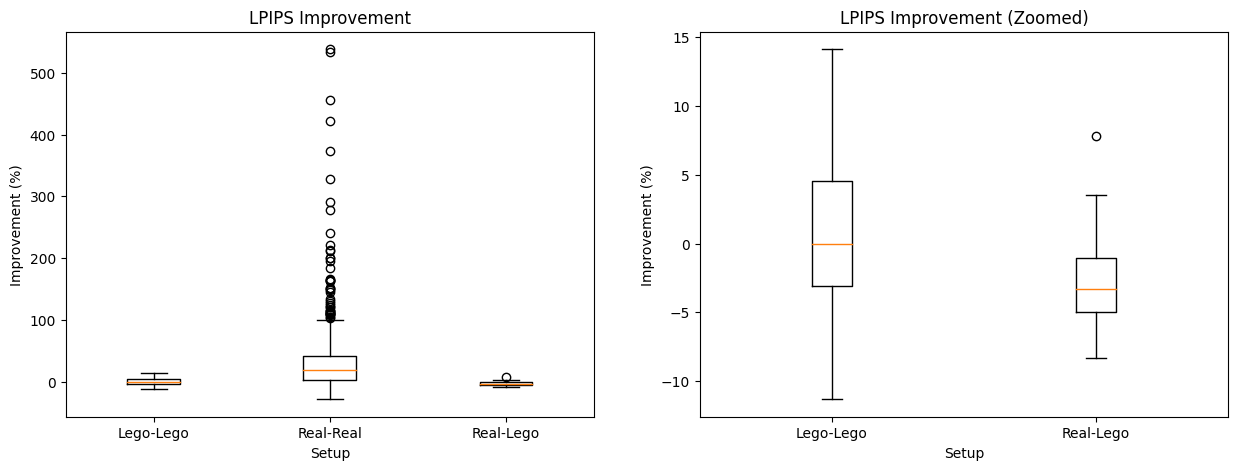

In [57]:
psnr_data = [improvement_psnr_per_image, improvement_psnr_per_image_real, improvement_psnr_per_image_lego]
lpips_data = [improvement_lpips_per_image, improvement_lpips_per_image_real, improvement_lpips_per_image_lego]

# plot the average improvement in PSNR and LPIPS for step 1 and 3 alone in boxplot
psnr_data_zoom = [improvement_psnr_per_image, improvement_psnr_per_image_lego]
lpips_data_zoom = [improvement_lpips_per_image, improvement_lpips_per_image_lego]



labels_zoom = ['Setup 1', 'Setup 3']
categories_label_zoom = ['Lego-Lego', 'Real-Lego']


labels = ['Setup 1', 'Setup 2', 'Setup 3']
categories_label = ['Lego-Lego', 'Real-Real', 'Real-Lego']

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].boxplot(psnr_data, labels=labels)
ax[0].set_title('PSNR Improvement')
ax[0].set_ylabel('Improvement (%)')
ax[0].set_xlabel('Setup')
ax[0].set_xticklabels(categories_label)
ax[1].boxplot(psnr_data_zoom, labels=labels_zoom)
ax[1].set_title('PSNR Improvement (Zoomed)')
ax[1].set_ylabel('Improvement (%)')
ax[1].set_xlabel('Setup')
ax[1].set_xticklabels(categories_label_zoom)
plt.show()




fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].boxplot(lpips_data, labels=labels)
ax[0].set_title('LPIPS Improvement')
ax[0].set_ylabel('Improvement (%)')
ax[0].set_xlabel('Setup')
ax[0].set_xticklabels(categories_label)
ax[1].boxplot(lpips_data_zoom, labels=labels_zoom)
ax[1].set_title('LPIPS Improvement (Zoomed)')
ax[1].set_ylabel('Improvement (%)')
ax[1].set_xlabel('Setup')
ax[1].set_xticklabels(categories_label_zoom)
plt.show()




ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3,) and arg 1 with shape (144,).

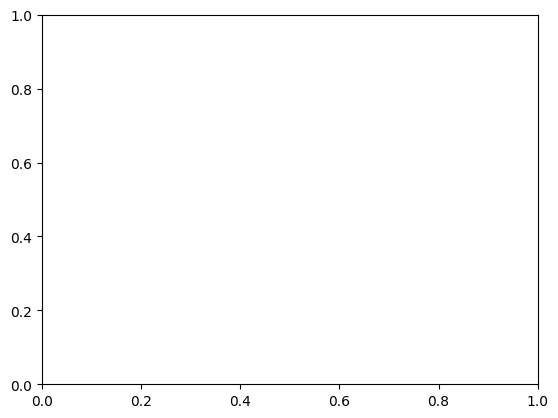

In [ ]:
# Plot PSNR
fig, ax = plt.subplots()
width = 0.35  # the width of the bars
bar_width = 0.2  # the width of each bar chart

for i, setup_data in enumerate(psnr_data):
    x_positions = np.arange(len(labels)) + i * bar_width
    bars = ax.bar(x_positions, setup_data, width=bar_width, label=f'{categories_label[i]}')

    # Calculate and display percentage change
    for j, bar in enumerate(bars):
        height = bar.get_height()
        improvement = psnr_improvements[i] if j == 1 else 0  # Display improvement only for denoised/restored
        if j == 1:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f'{height:.2f}\n({improvement:+.2f}%)',
                ha='center',
                va='bottom',
                color='black'
            )
        else:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f'{height:.2f}',
                ha='center',
                va='bottom',
                color='black'
            )

ax.set_ylabel('PSNR')
ax.set_title('PSNR Comparison for Different Setups')
ax.set_xticks(np.arange(len(labels)) + bar_width)
ax.set_xticklabels(labels)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust ylim to add more y-axis space
ax.set_ylim(top=ax.get_ylim()[1] * 1.1)

plt.show()

# Plot LPIPS
fig, ax = plt.subplots()
for i, setup_data in enumerate(lpips_data):
    x_positions = np.arange(len(labels)) + i * bar_width
    bars = ax.bar(x_positions, setup_data, width=bar_width, label=f'{categories_label[i]}')

    # Calculate and display percentage change
    for j, bar in enumerate(bars):
        height = bar.get_height()
        improvement = lpips_improvements[i] if j == 1 else 0  # Display improvement only for denoised/restored
        if j == 1:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f'{height:.2f}\n({improvement:+.2f}%)',
                ha='center',
                va='bottom',
                color='black'
            )
        else:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f'{height:.2f}',
                ha='center',
                va='bottom',
                color='black'
            )

ax.set_ylabel('LPIPS')
ax.set_title('LPIPS Comparison for Different Setups')
ax.set_xticks(np.arange(len(labels)) + bar_width)
ax.set_xticklabels(labels)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust ylim to add more y-axis space
ax.set_ylim(top=ax.get_ylim()[1] * 1.2)

plt.show()